# TUTORIAL #2 - STRUCTURAL CONNECTIVITY OF THE ALLEN MOUSE BRAIN WITH AUTOMATIC PARCELLATION
### By Giovanni Rabuffo - giovanni.rabuffo@univ-amu.fr
### Based on the work of Francesca Melozzi et al - The Virtual Mouse Brain open source data DOI: https://doi.org/10.1523/ENEURO.0111-17.2017 

In [2]:
%pylab nbagg
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as io
import nibabel as nib
import copy
import pandas as pd

# Install allensdk first!

# IMPORT data

### MouseConnectivityCache...

In [4]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
# we set the data resolution to 100 microns**3
mcc = MouseConnectivityCache(manifest_file='/Users/giovanni/Documents/GitHub/fufo/data/Interim/Allen/Allen_experiments/manifest.json',resolution=100)

### Structure_tree to get info on some structures...

In [5]:
structure_tree = mcc.get_structure_tree()

### Annotation volumes and template

In [6]:
# download from the AllenSDK the annotation volume, the template volume
vol, annot_info = mcc.get_annotation_volume()
template, template_info = mcc.get_template_volume()

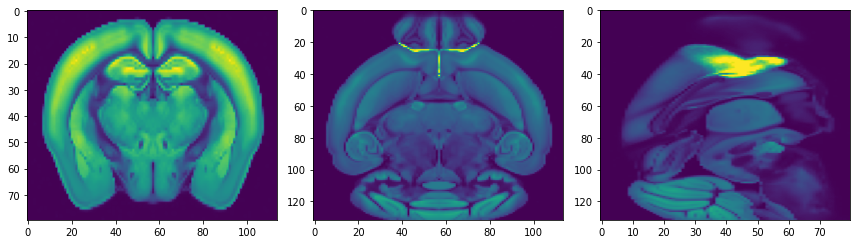

In [7]:
depth=2.
plt.figure(figsize=(12,3.5))
slice_idx=int(np.shape(template)[0]/depth);slice_idy=int(np.shape(template)[1]/depth);slice_idz=int(np.shape(template)[2]/depth)
plt.subplot(131);plt.imshow(template[slice_idx,:,:],aspect='auto',cmap='viridis')
plt.subplot(132);plt.imshow(template[:,slice_idy,:],aspect='auto',cmap='viridis')
plt.subplot(133);plt.imshow(template[:,:,slice_idz],aspect='auto',cmap='viridis')
plt.tight_layout()
plt.show()

### Define Maps from acronyms to ids

In [8]:
ia_map = structure_tree.get_id_acronym_map()
ai_map = {item:key for key, item in ia_map.items()}

# Automatic ROIs selection

In [9]:
# the method creates a dictionary with information about which experiments need to be downloaded
def dictionary_builder(transgenic_line):
    # open up a list of all of the experiments
    all_experiments = mcc.get_experiments(dataframe=True, cre=transgenic_line)
    # build dict of injection structure id to experiment list
    ist2e = {}
    for eid in all_experiments.index:
        isti = all_experiments.loc[eid]['primary_injection_structure']
        if isti not in ist2e:
            ist2e[isti] = []
        ist2e[isti].append(eid)
    return ist2e

# the method creates a dictionary with information about which experiments need to be downloaded
ist2e = dictionary_builder(False)

In [10]:
len(ist2e.keys())

123

### Construct the projection matrices for all the regions

In [11]:
# The function downloads experiments necessary to build the connectivity and returns the projection maps
def download_an_construct_matrix(weighting, ist2e, transgenic_line):
    projmaps = {}
    if weighting == 3:  # download projection energy
        for isti, elist in ist2e.items():
            projmaps[isti] = mcc.get_projection_matrix(
                experiment_ids=elist,
                projection_structure_ids=list(ist2e),  # summary_structure_ids,
                parameter='projection_energy')
            print('injection site id', isti, ' has ', len(elist), ' experiments with pm shape ',
                        projmaps[isti]['matrix'].shape)
    else:  # download projection density:
        eli=[]
        for isti, elist in ist2e.items():
            projmaps[isti] = mcc.get_projection_matrix(
                experiment_ids=elist,
                projection_structure_ids=list(ist2e),  # summary_structure_ids,
                parameter='projection_density')
            eli=list(set(eli + elist))
            print('injection site id', isti, ' has ', len(elist), ' experiments with pm shape ',
                        projmaps[isti]['matrix'].shape)
        if weighting == 1:  # download injection density
            injdensity = {}
            #all_experiments = mcc.get_experiments(dataframe=True, cre=transgenic_line)
            for exp_id in eli:#all_experiments['id']:
                inj_d = mcc.get_injection_density(exp_id, file_name=None)
                # all the experiments have only an injection sites (only 3 coordinates),
                # thus it is possible to sum the injection matrix
                injdensity[exp_id] = (np.sum(inj_d[0]) / np.count_nonzero(inj_d[0]))
                print('Experiment id', exp_id, ', the total injection density is ', injdensity[exp_id])
            # in this case projmaps will contain PD/ID
            for inj_id in range(len(list(projmaps.values()))):
                index = 0
                for exp_id in list(projmaps.values())[inj_id]['rows']:
                    list(projmaps.values())[inj_id]['matrix'][index] = list(projmaps.values())[inj_id]['matrix'][index] / \
                                                                 injdensity[exp_id]
                    index += 1
    return projmaps

In [12]:
projmaps = download_an_construct_matrix(1, ist2e, False)

injection site id 104  has  6  experiments with pm shape  (6, 369)
injection site id 12  has  6  experiments with pm shape  (6, 369)
injection site id 131  has  4  experiments with pm shape  (4, 369)
injection site id 541  has  4  experiments with pm shape  (4, 369)
injection site id 194  has  9  experiments with pm shape  (9, 369)
injection site id 385  has  40  experiments with pm shape  (40, 369)
injection site id 111  has  8  experiments with pm shape  (8, 369)
injection site id 345  has  9  experiments with pm shape  (9, 369)
injection site id 879  has  5  experiments with pm shape  (5, 369)
injection site id 128  has  29  experiments with pm shape  (29, 369)
injection site id 136  has  14  experiments with pm shape  (14, 369)
injection site id 39  has  12  experiments with pm shape  (12, 369)
injection site id 215  has  3  experiments with pm shape  (3, 369)
injection site id 64  has  2  experiments with pm shape  (2, 369)
injection site id 30  has  2  experiments with pm shape  

In [13]:
# Save a dictionary into a pickle file.
import pickle
path='/Users/giovanni/Documents/GitHub/fufo/data/Interim/Allen/Tutorial_Github/'
pickle.dump( projmaps, open(path+'projmaps_tutorial_Maria.p', "wb" ) )

In [90]:
# load projmaps
projmaps = pickle.load(open(path+'projmaps_tutorial_Maria.p', "rb" ) )

### Processing and cleaning of the projmaps

In [91]:
# the method cleans the file projmaps in 2 steps
def pms_cleaner(input_projmaps):
    projmaps_clean1={}
    # 1) Set all the target sites to be the same for all the injection sites
    for inj_id in input_projmaps:
        c=input_projmaps[inj_id]['columns']
        m=input_projmaps[inj_id]['matrix']
        excl=[]
        for ic in range(len(c)):
            if c[ic]['structure_id'] not in input_projmaps.keys():
                excl.append(ic)
        for icc in excl[::-1]:
            c.pop(icc)
        m=np.delete(m,excl,axis=1)
        projmaps_clean1[inj_id]={'columns':c,'matrix':m,'rows':input_projmaps[inj_id]['rows']}
    print('In total %d injection sites have been removed after imposing that targets and injection sites are the same. New number of keys in projmaps is N=%d'%(len(input_projmaps.keys())-len(projmaps_clean1.keys()),len(projmaps_clean1.keys())))
    
    projmaps={}
    # 2) Remove Nan
    for inj_id in projmaps_clean1:
        c=projmaps_clean1[inj_id]['columns']
        m=projmaps_clean1[inj_id]['matrix']
        excl=[]
        for ic in range(len(c)):
            if 1 in np.isnan(m[:,ic]):
                excl.append(ic)
        for icc in excl[::-1]:
            c.pop(icc)
        m=np.delete(m,excl,axis=1)
        projmaps[inj_id]={'columns':c,'matrix':m,'rows':projmaps_clean1[inj_id]['rows']}
    print('In total %d injection sites have been removed after imposing that there is no Nan. New number of keys in projmaps is N=%d'%(len(projmaps_clean1.keys())-len(projmaps.keys()),len(projmaps.keys())))
    return projmaps

In [92]:
projmaps = pms_cleaner(projmaps)

In total 0 injection sites have been removed after imposing that targets and injection sites are the same. New number of keys in projmaps is N=123
In total 0 injection sites have been removed after imposing that there is no Nan. New number of keys in projmaps is N=123


In [93]:
def areas_volume_threshold(projmaps_old, vol_thresh, resolution):
    """
    the method includes in the parcellation only brain regions whose volume is greater than vol_thresh
    """
    threshold = vol_thresh / (resolution ** 3)
    id_all=list(projmaps_old.keys())
    id_ok = []
    
    projmaps_rmvol1=copy.deepcopy(projmaps_old)
    for ID in projmaps_old:
        mask, _ = mcc.get_structure_mask(ID)
        tot_voxels = int((np.count_nonzero(mask)) / 2)  # mask contains both left and right hemisphere
        if tot_voxels > threshold:
            id_ok.append(ID)
    print('Regions removed because too small')
    print(list(set(id_all)-set(id_ok)))
    
    print('Big regions left')
    print(id_ok)
    
    # Remove keys of all areas that are not in id_ok from the injection list
    for checkid in id_all:
        if checkid not in id_ok:
            projmaps_rmvol1.pop(checkid, None)
            
    # Remove areas that are not in id_ok from target list (columns+matrix)
    projmaps_rmvol={}
    for inj_id in projmaps_rmvol1:
        c=projmaps_rmvol1[inj_id]['columns']
        m=projmaps_rmvol1[inj_id]['matrix']
        excl=[]
        for ic in range(len(c)):
            if c[ic]['structure_id'] not in id_ok:
                excl.append(ic)
        for icc in excl[::-1]:
            c.pop(icc)
        m=np.delete(m,excl,axis=1)
        projmaps_rmvol[inj_id]={'columns':c,'matrix':m,'rows':projmaps_rmvol1[inj_id]['rows']}
    return projmaps_rmvol

# Select Resolution
### changing these values will regulate the number of selected ROIs

In [94]:
#'To build the volume and the connectivity select only the areas that have a volume greater than (micron^3): ','default': '1000000000'}]
resolution=120
vol_thresh=1000000000

#Note: if you want to change resolution, restart from reloading the projmaps

In [95]:
# #'To build the volume and the connectivity select only the areas that have a volume greater than (micron^3): ','default': '1000000000'}]
# resolution=1000
# vol_thresh=1000000000

In [96]:
projmaps=areas_volume_threshold(projmaps, vol_thresh, resolution)

Regions removed because too small
[1, 131, 133, 7, 135, 266, 651, 12, 394, 15, 1039, 271, 912, 531, 19, 533, 534, 23, 147, 149, 151, 27, 155, 30, 414, 35, 38, 422, 423, 169, 170, 44, 685, 944, 181, 184, 58, 59, 186, 63, 64, 66, 583, 72, 75, 843, 206, 83, 470, 88, 91, 475, 96, 226, 100, 101, 402, 616, 106, 235, 491, 366, 115, 629, 118, 374, 250, 126, 127]
Big regions left
[104, 541, 194, 385, 111, 345, 879, 128, 136, 39, 215, 4, 672, 295, 329, 928, 502, 1020, 918, 319, 378, 202, 56, 429, 48, 985, 1002, 361, 337, 218, 726, 342, 1017, 463, 1041, 369, 294, 382, 353, 566, 895, 262, 362, 409, 146, 395, 159, 258, 952, 920, 647, 723, 1025, 731]


In [97]:
projmaps=areas_volume_threshold(projmaps, vol_thresh, resolution)

Regions removed because too small
[]
Big regions left
[104, 541, 194, 385, 111, 345, 879, 128, 136, 39, 215, 4, 672, 295, 329, 928, 502, 1020, 918, 319, 378, 202, 56, 429, 48, 985, 1002, 361, 337, 218, 726, 342, 1017, 463, 1041, 369, 294, 382, 353, 566, 895, 262, 362, 409, 146, 395, 159, 258, 952, 920, 647, 723, 1025, 731]


### Organize labels and create parcellation of the Allen Atlas according to the ROIs

In [98]:
def create_file_order(projmaps, structure_tree):
    """
    the method creates file order and keyord that will be the link between the structural conn
    order and the id key in the Allen database
    """
    order = {}
    for target_id in projmaps.keys():
        order[structure_tree.get_structures_by_id([target_id])[0]['graph_order']] = [target_id]
        order[structure_tree.get_structures_by_id([target_id])[0]['graph_order']].append(
            structure_tree.get_structures_by_id([target_id])[0]['acronym'])
        order[structure_tree.get_structures_by_id([target_id])[0]['graph_order']].append(
            structure_tree.get_structures_by_id([target_id])[0]['name'])#name
    key_ord = list(order)
    key_ord.sort()
    return order, key_ord

In [99]:
# the method creates file order and keyword that will be the link between the SC order and the
# id key in the Allen database
[order, key_ord] = create_file_order(projmaps, structure_tree)

# order has graph_order as keys and (target_id ,acronyms, region labels) as values
labels=np.asarray(list(order.values()))[:,1]
regions=np.asarray(list(order.values()))[:,2]

In [100]:
def mouse_brain_visualizer(vol, order, key_ord, structure_tree, projmaps):
    """
    the method returns a volume indexed between 0 and N-1, with N=tot brain areas in the parcellation.
    -1=background and areas that are not in the parcellation
    """
    tot_areas = len(key_ord) * 2
    indexed_vec = np.arange(tot_areas).reshape(tot_areas, )
    # vec indexed between 0 and (N-1), with N=total number of area in the parcellation
    indexed_vec = indexed_vec + 1  # vec indexed between 1 and N
    indexed_vec = indexed_vec * (10 ** (-(1 + int(np.log10(tot_areas)))))
    # vec indexed between 0 and 0,N (now all the entries of vec_indexed are < 1 in order to not create confusion
    # with the entry of Vol (always greater than 1)
    vol_r = vol[:, :, :int(vol.shape[2] / 2)]
    vol_r = vol_r.astype(np.float64)
    vol_l = vol[:, :, int(vol.shape[2] / 2):]
    vol_l = vol_l.astype(np.float64)
    index_vec = 0  # this is the index of the vector
    left = int(len(indexed_vec) / 2)
    for graph_ord_inj in key_ord:
        node_id = order[graph_ord_inj][0]
        if node_id in vol_r:  # check if the area is in the annotation volume
            vol_r[vol_r == node_id] = indexed_vec[index_vec]
            vol_l[vol_l == node_id] = indexed_vec[index_vec + left]
        child = []
        for ii in range(len(structure_tree.children([node_id])[0])):
            child.append(structure_tree.children([node_id])[0][ii]['id'])
        while len(child) != 0:
            if (child[0] in vol_r) and (child[0] not in list(projmaps)):
                vol_r[vol_r == child[0]] = indexed_vec[index_vec]
                vol_l[vol_l == child[0]] = indexed_vec[index_vec + left]
            child.remove(child[0])
        index_vec += 1  # index of vector
    vol_parcel = np.concatenate((vol_r, vol_l), axis=2)
    
    vol_parcel[vol_parcel >= 1] = 0  # set all the areas not in the parcellation to 0 since the background is zero
    vol_parcel = vol_parcel * (10 ** (1 + int(np.log10(tot_areas))))  # return to indexed between
    # 1 and N (with N=tot number of areas in the parcellation)
    vol_parcel = vol_parcel - 1  # with this operation background and areas not in parcellation will be -1
    # and all the others with the indexed between 0 and N-1
    vol_parcel = np.round(vol_parcel)
    vol_parcel = rotate_reference(vol_parcel)
    return vol_parcel

In [101]:
# the method rotate the Allen 3D (x1,y1,z1) reference in the TVB 3D reference (x2,y2,z2).
# the relation between the different reference system is: x1=z2, y1=x2, z1=y2
def rotate_reference(allen):
    # first rotation in order to obtain: x1=x2, y1=z2, z1=y2
    vol_trans = np.zeros((allen.shape[0], allen.shape[2], allen.shape[1]), dtype=float)
    for x in range(allen.shape[0]):
        vol_trans[x, :, :] = (allen[x, :, :][::-1]).transpose()

    # second rotation in order to obtain: x1=z2, y1=x1, z1=y2
    allen_rotate = np.zeros((allen.shape[2], allen.shape[0], allen.shape[1]), dtype=float)
    for y in range(allen.shape[1]):
        allen_rotate[:, :, y] = (vol_trans[:, :, y]).transpose()
    return allen_rotate


In [102]:
# the method returns a volume indexed between 0 and N-1, with N=tot brain areas in the parcellation.
# -1=background and areas that are not in the parcellation
vol_parcel = mouse_brain_visualizer(vol, order, key_ord, structure_tree, projmaps)

In [103]:
vol_parcel.shape

(114, 132, 80)

### Construct the Structural Connectivity and the tract lengths

In [106]:
# the method builds the Structural Connectivity (SC) matrix

def construct_structural_conn(projmaps, order, key_ord):
    len_right = len(list(projmaps))
    structural_conn = np.zeros((len_right, 2 * len_right), dtype=float)
    row = -1
    for graph_ord_inj in key_ord:
        row += 1
        inj_id = order[graph_ord_inj][0]
        columns = projmaps[inj_id]['columns']
        matrix = projmaps[inj_id]['matrix']
        # average on the experiments (NB: if there are NaN values not average!)
        if np.isnan(np.sum(matrix)):
            print('There is a Nan in matrix of injection structure %d'%inj_id)
        else:
            matrix = np.mean(matrix,axis=0) #(np.array([sum(matrix[:, i]) for i in range(matrix.shape[1])]) / (matrix.shape[0]))
        # order the target
        col = -1
        for graph_ord_targ in key_ord:
            col += 1
            targ_id = order[graph_ord_targ][0]
            for index in range(len(columns)):
                if columns[index]['structure_id'] == targ_id:
                    if columns[index]['hemisphere_id'] == 2:
                        structural_conn[row, col] = matrix[index]
                    if columns[index]['hemisphere_id'] == 1:
                        structural_conn[row, col + len_right] = matrix[index]
    # save the complete matrix (both left and right inj):
    first_quarter = structural_conn[:, :int(structural_conn.shape[1] / 2)]
    second_quarter = structural_conn[:, int(structural_conn.shape[1] / 2):]
    sc_down = np.concatenate((second_quarter, first_quarter), axis=1)
    structural_conn = np.concatenate((structural_conn, sc_down), axis=0)
    structural_conn = structural_conn / (np.amax(structural_conn))  # normalize the matrix
    return structural_conn


# the method returns the centres of the brain areas in the selected parcellation

def construct_centres(order, key_ord):
    centres = np.zeros((len(key_ord) * 2, 3), dtype=float)
    names = []
    acro = []
    row = -1
    for graph_ord_inj in key_ord:
        node_id = order[graph_ord_inj][0]
        coord = [0, 0, 0]
        mask, _ = mcc.get_structure_mask(node_id)
        mask = rotate_reference(mask)
        mask_r = mask[:int(mask.shape[0] / 2), :, :]
        xyz = np.where(mask_r)
        if xyz[0].shape[0] > 0:  # Check if the area is in the annotation volume
            coord[0] = np.mean(xyz[0])
            coord[1] = np.mean(xyz[1])
            coord[2] = np.mean(xyz[2])
        row += 1
        centres[row, :] = coord
        coord[0] = (mask.shape[0]) - coord[0]
        centres[row + len(key_ord), :] = coord
        n = order[graph_ord_inj][2]
        N = order[graph_ord_inj][1]
        right = 'Right '
        names.append(str(right+n))
        acro.append(str(right+N))
    for graph_ord_inj in key_ord:
        n = order[graph_ord_inj][2]
        N = order[graph_ord_inj][1]        
        left = 'Left '
        names.append(str(left+n))
        acro.append(str(left+N))
    return centres, names, acro


# the method returns the tract lengths between the brain areas in the selected parcellation

def construct_tract_lengths(centres):
    len_right = int(len(centres) / 2)
    tracts = np.zeros((len_right, len(centres)), dtype=float)
    for inj in range(len_right):
        center_inj = centres[inj]
        for targ in range(len_right):
            targ_r = centres[targ]
            targ_l = centres[targ + len_right]
            tracts[inj, targ] = np.sqrt(
                (center_inj[0] - targ_r[0]) ** 2 + (center_inj[1] - targ_r[1]) ** 2 + (center_inj[2] - targ_r[2]) ** 2)
            tracts[inj, targ + len_right] = np.sqrt(
                (center_inj[0] - targ_l[0]) ** 2 + (center_inj[1] - targ_l[1]) ** 2 + (center_inj[2] - targ_l[2]) ** 2)
    # Save the complete matrix (both left and right inj):
    first_quarter = tracts[:, :int(tracts.shape[1] / 2)]
    second_quarter = tracts[:, int(tracts.shape[1] / 2):]
    tracts_down = np.concatenate((second_quarter, first_quarter), axis=1)
    tracts = np.concatenate((tracts, tracts_down), axis=0)
    return tracts

In [107]:
# the method builds the Structural Connectivity (SC) matrix
structural_conn = construct_structural_conn(projmaps, order, key_ord)

# the method returns the coordinate of the centres and the name of the brain areas in the selected parcellation
[centres, names, acronyms] = construct_centres(order, key_ord)

# the method returns the tract lengths between the brain areas in the selected parcellation
tract_lengths = construct_tract_lengths(centres)

# Volume Sizes
Vol_size=np.unique(vol_parcel,return_counts=True)[1][1:]

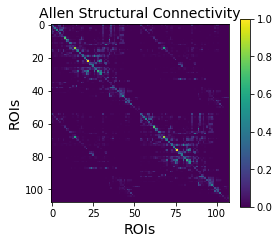

In [108]:
plt.figure(figsize=(4,4))
plt.title('Allen Structural Connectivity',fontsize=14)
plt.imshow(structural_conn,interpolation='nearest',cmap='viridis')
plt.xlabel('ROIs',fontsize=14);plt.ylabel('ROIs',fontsize=14)
plt.colorbar(shrink=0.75)
plt.tight_layout()
plt.show()

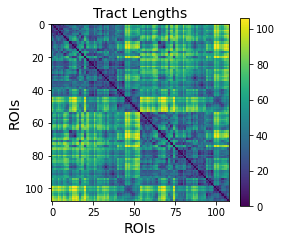

In [109]:
plt.figure(figsize=(4,4))
plt.title('Tract Lengths',fontsize=14)
plt.imshow(tract_lengths,interpolation='nearest',cmap='viridis')
plt.xlabel('ROIs',fontsize=14);plt.ylabel('ROIs',fontsize=14)
plt.colorbar(shrink=0.75)
plt.tight_layout()
plt.show()

In [110]:
# ordered ROIs names
names

['Right Primary motor area',
 'Right Primary somatosensory area, nose',
 'Right Primary somatosensory area, barrel field',
 'Right Primary somatosensory area, lower limb',
 'Right Primary somatosensory area, mouth',
 'Right Primary somatosensory area, upper limb',
 'Right Primary somatosensory area, trunk',
 'Right Supplemental somatosensory area',
 'Right Primary auditory area',
 'Right Lateral visual area',
 'Right Primary visual area',
 'Right Anterior cingulate area, dorsal part',
 'Right Anterior cingulate area, ventral part',
 'Right Orbital area, lateral part',
 'Right Orbital area, medial part',
 'Right Agranular insular area, dorsal part',
 'Right Agranular insular area, posterior part',
 'Right Retrosplenial area, dorsal part',
 'Right Temporal association areas',
 'Right Ectorhinal area',
 'Right Anterior olfactory nucleus',
 'Right Cortical amygdalar area, posterior part',
 'Right Postpiriform transition area',
 'Right Field CA1',
 'Right Field CA3',
 'Right Dentate gyrus',

#  Plot Brain Region

In [187]:
# Select superficial voxels
surface_voxels=-10*np.ones((np.shape(vol_parcel)[0],np.shape(vol_parcel)[1])) 
for i in range(np.shape(vol_parcel)[0]):
    for j in range(np.shape(vol_parcel)[1]):
        if len(np.where(vol_parcel[i,j,:]!=-1)[0])>0:
            surface_voxels[i,j]=vol_parcel[i,j,:][np.where(vol_parcel[i,j,:]!=-1)[0][-1]]

In [188]:
def plot_roi(vol_parcel,name_roi):
    index=np.where(np.asarray(names)==name_roi)[0][0]
    highlight_val=2*np.max(vol_parcel)
    plt.figure(figsize=(12,4));plt.suptitle('Highlight - %s'%name_roi)
    slice_idx=int(np.shape(vol_parcel)[0]/3.);slice_idy=int(np.shape(vol_parcel)[1]/1.5);slice_idz=int(np.shape(vol_parcel)[2]/1.3)
    plt.subplot(141);plt.title('axial')
    plt.imshow(np.where(vol_parcel==index,highlight_val,vol_parcel)[slice_idx,:,:],vmin=-1,vmax=highlight_val)
    plt.subplot(142);plt.title('coronal')
    plt.imshow(np.where(vol_parcel==index,highlight_val,vol_parcel)[:,slice_idy,:],vmin=-1,vmax=highlight_val)
    plt.subplot(143);plt.title('sagittal')
    plt.imshow(np.where(vol_parcel==index,highlight_val,vol_parcel)[:,:,slice_idz],vmin=-1,vmax=highlight_val)
    plt.subplot(144);plt.title('Cortex view from top')
    plt.imshow(np.where(surface_voxels==index,highlight_val,surface_voxels)[:,:],vmin=-1,vmax=highlight_val)
    plt.tight_layout()
    plt.show()

In [189]:
def plot_roi_on_template(vol_parcel,template,name_roi):
    template=rotate_reference(template)
    index=np.where(np.asarray(names)==name_roi)[0][0]
    highlight_val=2*np.max(template)
    
    plt.figure(figsize=(14,5));plt.suptitle('Highlight - %s'%name_roi)
    slice_idx=int(np.shape(template)[0]/3.);slice_idy=int(np.shape(template)[1]/1.5);slice_idz=int(np.shape(template)[2]/1.3)
    plt.subplot(131);plt.title('axial')
    plt.imshow(np.where(vol_parcel==index,highlight_val,template)[slice_idx,:,:],vmin=-1,vmax=highlight_val)
    plt.subplot(132);plt.title('coronal')
    plt.imshow(np.where(vol_parcel==index,highlight_val,template)[:,slice_idy,:],vmin=-1,vmax=highlight_val)
    plt.subplot(133);plt.title('sagittal')
    plt.imshow(np.where(vol_parcel==index,highlight_val,template)[:,:,slice_idz],vmin=-1,vmax=highlight_val)
    plt.tight_layout()
    plt.show()
    

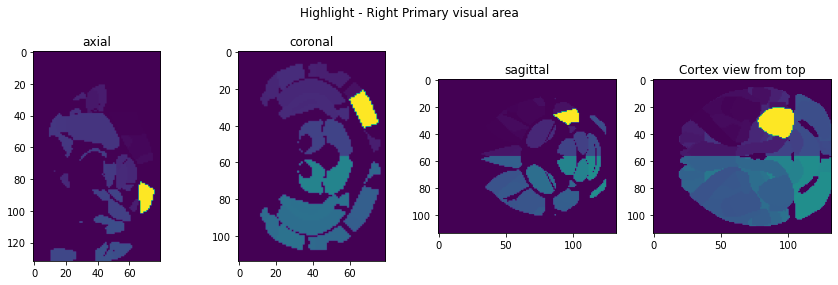

In [190]:
plot_roi(vol_parcel,'Right Primary visual area')

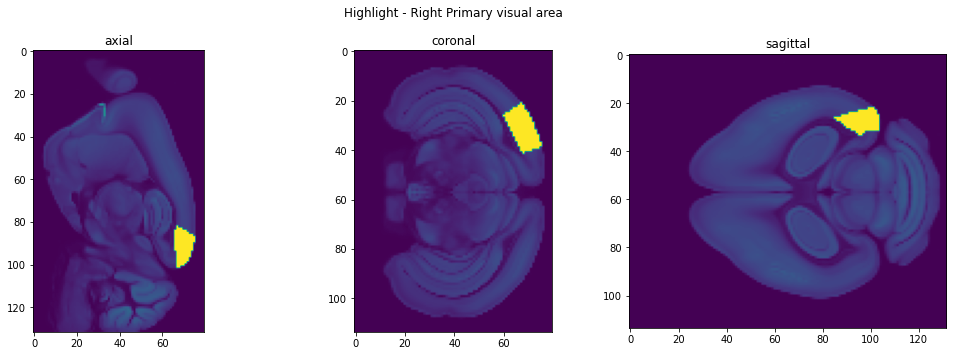

In [191]:
plot_roi_on_template(vol_parcel,template,'Right Primary visual area')